# policy gradient (REINFORCE) with PyTorch
it is better for continuous envs

In [1]:
%reset -f
!rm *

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!pip list

Package                                  Version
---------------------------------------- --------------
aiohappyeyeballs                         2.4.0
aiohttp                                  3.10.5
aiosignal                                1.3.1
alembic                                  1.13.2
altgraph                                 0.17.4
anyio                                    4.4.0
apache-airflow                           2.10.1
apache-airflow-providers-common-compat   1.2.0
apache-airflow-providers-common-io       1.4.0
apache-airflow-providers-common-sql      1.16.0
apache-airflow-providers-fab             1.3.0
apache-airflow-providers-ftp             3.11.0
apache-airflow-providers-http            4.13.0
apache-airflow-providers-imap            3.7.0
apache-airflow-providers-smtp            1.8.0
apache-airflow-providers-sqlite          3.9.0
apispec                                  6.6.1
argcomplete                              3.5.0
argon2-cffi                              2

In [3]:
import gym
import numpy as np
import torch

In [4]:
env = gym.make('CartPole-v0', render_mode='rgb_array')

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [5]:
state1 = env.reset()[0]
action1 = env.action_space.sample()
newState, reward, done, info, _ = env.step(action1)

# print(state1, '\n', action1, '\n', newState, reward, done, info,_)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
'''setting up the policy network'''

inp_layer_dim = env.observation_space.shape[0]
hidden_layer1_dim = 150
hidden_layer2_dim = 100
outp_layer_dim = env.action_space.n

'''policy network'''
model = torch.nn.Sequential(
    torch.nn.Linear(inp_layer_dim, hidden_layer1_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer1_dim, hidden_layer2_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer2_dim ,outp_layer_dim),
    torch.nn.Softmax()
)


'''defining adam optimizer'''
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


'''computing the discounted rewards'''
def discounted_rewards(rewards, gamma=0.99):
    rewards_len = len(rewards)
    
    '''Computes exponentially decaying rewards'''
    discounted_reward = torch.pow(gamma, torch.arange(rewards_len).float())
    
    '''Normalizes the rewards to be within the [0,1] interval to improve numerical stability'''
    discounted_reward /= discounted_reward.max()
    return discounted_reward


'''back propagation'''
def loss_function(predictions, r):
    return -torch.sum(r * torch.log(predictions))

In [28]:
'''The REINFORCE training loop'''
max_DUR = 200
max_Episodes = 300
gamma = 0.99 
'''A list to keep track of the episode length over training time'''
scores = []
set_of_ep_lens = []
weight_change_observation1 = []
weight_change_observation2 = []
for episode in range(max_Episodes):
    current_state = env.reset()[0]
    done = False
    
    '''A list of state, action, rewards (but we ignore the reward)'''
    transitions = []
    
    '''while in the Episode'''
    for t in range(max_DUR):
        
        '''get the action probability'''
        action_prob = model(torch.from_numpy(current_state).float())
        
        '''Selects an action stochastically'''
        action = np.random.choice(np.array([0,1]), p= action_prob.data.numpy())
        
        previous_state = current_state
        
        '''taking the action in the environment'''
        current_state, reward, done, info, _ = env.step(action)
        
        '''storing the transitions'''
        transitions.append((previous_state, action, t + 1))
     
        '''If the game is lost, breaks out of the loop'''    
        if done:
            break
        
        '''storing the episode lenght'''
        episode_length = len(transitions)
        
        
        scores.append(episode_length)
        
        '''Collects all the rewards in the episode in a single tensor'''
        reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,)) ### torch.flip(dim) reorders the array from end to start
        
        '''Computes the discounted version of the rewards'''
        disc_rewards = discounted_rewards(reward_batch)
        
        '''collecting the states in the episode in a single tensor'''
        state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions]))
        
        '''collecting the actions in the episode in a single tensor'''
        action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions]))
        
        '''recomputing the action probabilities for all the states in the episode'''
        pred_batch = model(state_batch)
        
        '''Subsets the action-probabilities associated with the actions that were actually taken'''
        prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()  ##### .view() or .reshape() use for reshaping the tensors. torch.Tensor.long() brings elements from 32 to 64
        #### tensor.gather( dim, index, *, sparse_grad=False, out=None) gathers values along an axis specified by dim
        loss = loss_function(prob_batch, disc_rewards)
        
        optimizer.zero_grad()   ##### .zero_grad() Resets the gradients of all optimized torch
        loss.backward()
        optimizer.step()
        weight_change_observation1.append(list(model.parameters())[0][0][0])
    weight_change_observation2.append(list(model.parameters())[0][0][0])
    set_of_ep_lens.append(episode_length)

AttributeError: 'list' object has no attribute 'values'

In [27]:
# weights = list(model.parameters())
print(f"weights1: {weight_change_observation1}\n")
print(f"weights2: {weight_change_observation2}\n")
print(f"maximum length of a episode: {max(set_of_ep_lens)}")
print(f"number of episodes: {len(set_of_ep_lens)}")
# print(prob_batch.shape)
print(f"length of last episode: {set_of_ep_lens[max_Episodes-1]}")

weights1: [tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), tensor(-0.2636, grad_fn=<AsStridedBackward0>), te

<function matplotlib.pyplot.show(close=None, block=None)>

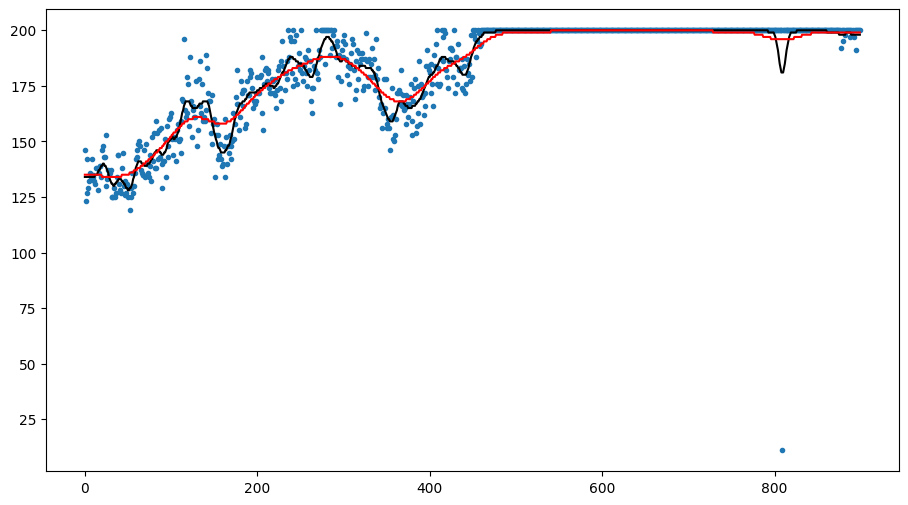

In [13]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  ## for smoothing
%matplotlib inline

# ysmoothed = gaussian_filter1d(y, sigma=2)
# plt.plot(x, ysmoothed)
# plt.show()
x = range(len(set_of_ep_lens))
y = set_of_ep_lens
y_smoothed = gaussian_filter1d(y, sigma=4)
y_smoothed_high = gaussian_filter1d(y, sigma=20)
plt.figure(figsize=(11,6))
plt.plot(x, y, '.')
plt.plot(x, y_smoothed, 'k')
plt.plot(x, y_smoothed_high, 'r')

plt.show
# plt.ylabel(set_of_ep_lens)
# plt.plot

In [43]:
'''Testing model'''
# Using the policy network to sample an action
testing_state = env.reset()[0]
output_prob = model(torch.from_numpy(testing_state).float())
nn_action = np.random.choice(np.array([0,1]), p = output_prob.data.numpy()) ### .data gives the numbers of pred and removes other strings like Tensor
state_new, reward, done, info, dic = env.step(nn_action)

print(testing_state, '\n',output_prob, '\n', nn_action, '\n', state_new, reward, done, info, dic)

[-0.01615289  0.034036   -0.01844477 -0.04161617] 
 tensor([1., 0.], grad_fn=<SoftmaxBackward0>) 
 0 
 [-0.01547217 -0.16081667 -0.01927709  0.24519067] 1.0 False False {}


In [44]:
# '''Saving'''
# torch.save(model.state_dict(), 'Reinforce_model_torch_nn_200_times_3500_episodes.pt')

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %code_wrap  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %mamba  %matplotlib  %micromamba  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%code_wrap  %%debug  %%file  %%html  %%javascript  %%js  %%latex 

In [ ]:
import math
math.sqrt()